In [167]:
import fbprophet
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from statsforecast.models import MSTL
from utils.data_wrangling import prepare_statsforecast_df, get_seasonal_components
from metrics import get_metrics
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional
import json
from datetime import datetime
import joblib
from paths import PATHS
import os
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import copy
warnings.simplefilter('ignore', ConvergenceWarning)

In [92]:
INIT = "2012-01-01"
END = "2023-04-30"
PERIOD = 24*365
HORIZON = 24*2

PROCESSED_DATA_DIR = PATHS['processed_data']
FCS_PATH = PATHS["forecasts_data"]
FORECASTS_FIG_DIR = PATHS['forecasts_figs']
MODELS_DIR = PATHS['models']

In [64]:
load = dw.ons_data(freq='h', ano_inicio=2012, ano_fim=2023, idreg="S")
df_load = dw.pipeline(load).loc[INIT:END,:]
df_load = df_load.iloc[-PERIOD:,:]
df_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-05-01 00:00:00 to 2023-04-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_reg      8760 non-null   category
 1   desc_reg    8760 non-null   category
 2   load_mwmed  8760 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 154.4 KB


In [65]:
ts = SerieTemporal(data=df_load, y_col = "load_mwmed", date_col_name = "date", test_size=HORIZON, frequency='h')

In [34]:
train, test = tw.train_test_split(df_load, test=HORIZON)
train_series = train.loc[:,"load_mwmed"]

# Prophet

## In-sample evaluation

In [15]:
data = train_series.reset_index()
data.columns = ['ds', 'y']

In [17]:
model = fbprophet.Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(data)

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


<Axes: xlabel='ds'>

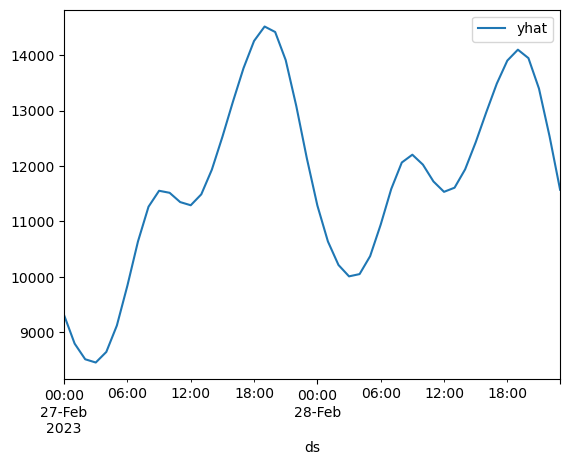

In [26]:
future = model.make_future_dataframe(periods=HORIZON, freq='H', include_history=False)
forecast = model.predict(future)
y = forecast[["ds","yhat"]].set_index("ds")
y.plot()

c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\user\anaconda3\envs\load_forecasting\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


<Axes: xlabel='ds'>

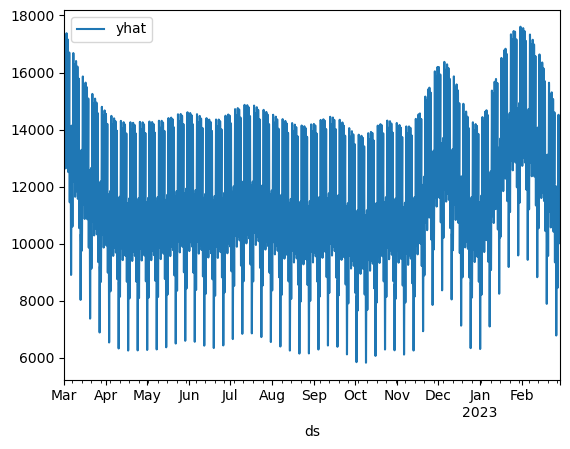

In [28]:
future = model.make_future_dataframe(periods=HORIZON, freq='H', include_history=True)
forecast = model.predict(future)
y = forecast[["ds","yhat"]].set_index("ds")
y.plot()

In [ ]:
# Fora de amostra
y.iloc[-HORIZON:].plot()

In [206]:
def holtwinters_model(data, seasonal_periods, trend, damped_trend, seasonal, freq):
    model = ExponentialSmoothing(data, seasonal_periods=seasonal_periods, trend=trend, damped_trend=damped_trend, seasonal=seasonal, freq=freq)
    model = model.fit()
    return model

def prophet_model(data):
    """Fits a Prophet model that is used in Projecoes and in cross validation. 

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    model = fbprophet.Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    model.fit(data)
    return model

class Projecoes:
    def __init__(self, 
                 ts: SerieTemporal):
        self.ts = ts
        self.ts_data = self.ts.train.reset_index()[[self.ts.date_col_name, self.ts.y_col]].copy()
        self.models = {}
        self.is_forecasts = {}
        self.oos_forecasts = {}
        self.forecasts_dir = FCS_PATH
        self.forecasts_fig_dir = FORECASTS_FIG_DIR
        self.models_dir = MODELS_DIR
        self.models_metrics = {}

    def plot_forecasting(self, 
                         yhat: pd.Series,
                         plot_name: str):
        """_summary_

        Args:
            yhat (pd.Series): _description_
            plot_name (str): _description_
        """
        plt.figure(figsize=(15,5))
        plt.plot(self.ts.test.index, yhat, label='Forecast', color="red")
        plt.scatter(self.ts.test.index, self.ts.test, label='Observado')
        plt.title(plot_name)
        plt.legend()
        plt.savefig(os.path.join(self.forecasts_fig_dir, f"{plot_name}.png"))
        plt.close()

    def mstl_fit_forecast(self,
                   level=[90],
                   ts_name_id= 'hourly_load',
                   write: bool=True,
                   save_model: bool=True,
                   model_name: str="MSTL") -> pd.DataFrame:
        """_summary_

        Args:
            level (list, optional): _description_. Defaults to [90].
            ts_name_id (str, optional): _description_. Defaults to 'hourly_load'.
            write (bool, optional): _description_. Defaults to True.
            save_model (bool, optional): _description_. Defaults to True.

        Returns:
            pd.DataFrame: _description_
        """
        df_sf = prepare_statsforecast_df(self.ts.train, ts_name_id)
        sf = StatsForecast(
            models=[MSTL(season_length=[self.ts.seasonality, self.ts.seasonality*7])],
            freq=self.ts.frequency
            )
        sf.fit(df_sf)
        self.models[model_name] = sf
        oos_forecast = sf.forecast(h=self.ts.horizon, level=level, fitted=True)[["ds", model_name]].set_index("ds")
        is_forecast = sf.forecast_fitted_values()[["ds", model_name]].set_index("ds")
        self.plot_forecasting(yhat=oos_forecast[model_name], plot_name=f"{model_name}")
        self.is_forecasts[model_name] = self.oos_forecasts[model_name] = self.models_metrics[model_name] = self.models_metrics[model_name]["oos"] = self.models_metrics[model_name]["is"] = {}
        self.is_forecasts[model_name] = is_forecast
        self.oos_forecasts[model_name] = oos_forecast
        self.models_metrics[model_name]["oos"] = get_metrics(oos_forecast, self.ts.test)
        self.models_metrics[model_name]["is"] = get_metrics(is_forecast, self.ts.train)

        df_sf = prepare_statsforecast_df(self.ts.full_series, ts_name_id)
        sf = StatsForecast(
            models=[MSTL(season_length=[self.ts.seasonality, self.ts.seasonality*7])],
            freq=self.ts.frequency
            )
        sf.fit(df_sf)
        self.models[model_name] = sf
        forecast = sf.forecast(h=self.ts.horizon, level=level)[["ds", model_name]]
        
        if write:
            now = datetime.now().strftime("%Y%m%d_%H%M%S")
            file_path = os.path.join(self.forecasts_dir, f"{model_name}_fc_{now}.parquet")
            forecast.to_parquet(file_path)
        if save_model:
            model_path = os.path.join(self.models_dir, f'{model_name}_joblib')
            joblib.dump(sf, model_path)
        return [model_name, forecast.set_index("ds")]
    
fm = Projecoes(ts=ts)

In [207]:
fm.mstl_fit_forecast()

['MSTL',
                              MSTL
 ds                               
 2023-05-01 00:00:00   9236.228516
 2023-05-01 01:00:00   8819.247070
 2023-05-01 02:00:00   8622.821289
 2023-05-01 03:00:00   8578.414062
 2023-05-01 04:00:00   8724.414062
 2023-05-01 05:00:00   9329.783203
 2023-05-01 06:00:00  10453.747070
 2023-05-01 07:00:00  11103.261719
 2023-05-01 08:00:00  11293.725586
 2023-05-01 09:00:00  11053.979492
 2023-05-01 10:00:00  11516.690430
 2023-05-01 11:00:00  11927.869141
 2023-05-01 12:00:00  11327.338867
 2023-05-01 13:00:00  11948.460938
 2023-05-01 14:00:00  12633.643555
 2023-05-01 15:00:00  13240.833008
 2023-05-01 16:00:00  13985.773438
 2023-05-01 17:00:00  14406.122070
 2023-05-01 18:00:00  15096.452148
 2023-05-01 19:00:00  14773.957031
 2023-05-01 20:00:00  14056.421875
 2023-05-01 21:00:00  13585.117188
 2023-05-01 22:00:00  12901.210938
 2023-05-01 23:00:00  11990.302734
 2023-05-02 00:00:00  10516.783203
 2023-05-02 01:00:00   9906.231445
 2023-05-02

In [197]:
fm.models_metrics

{'MSTL': {'oos': {'erro': array([-33568.406], dtype=float32),
   'mae': 809.0314397807291,
   'mse': 1057567.5309614728,
   'rmse': 1028.3810242130457,
   'mape': 0.08124374243697564,
   'smape': 0.07635138191150286,
   'r2': 0.5121732307239406},
  'is': {'erro': array([935.29395], dtype=float32),
   'mae': 75.58593568021968,
   'mse': 12812.125950027366,
   'rmse': 113.19066193828608,
   'mape': 0.006583375819308672,
   'smape': 0.0065816854258602215,
   'r2': 0.9976722049044459}}}